In [1]:
# %load_ext autoreload
# %autoreload 2
# load dataset 
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_utils
import RS_models

/mnt/hdd/eric/.conda/envs/a.samrs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/hdd/eric/.conda/envs/a.samrs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
from torchvision.datasets import VOCDetection
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2

In [3]:
from typing import Dict, Any, List
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import collections

In [4]:
# VOC 2007 dataset을 저장할 위치
path2data = '//mnt/hdd/eric/.tmp_ipy/00.Data/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [5]:
# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [6]:
# train, validation dataset을 생성합니다.
train_ds = RS_dataset.myVOCDetection(path2data, year='2007', image_set='train', download=False)
val_ds = RS_dataset.myVOCDetection(path2data, year='2007', image_set='test', download=False)

In [7]:
# 샘플 이미지 확인
idx = np.random.randint(0,100)
img, target, label = train_ds[idx]
colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 색상

In [8]:
img.shape

torch.Size([3, 375, 500])

In [9]:
target

[[306.0, 227.0, 380.0, 299.0], [196.0, 143.0, 309.0, 369.0]]

In [10]:
label

[19.0, 14.0]

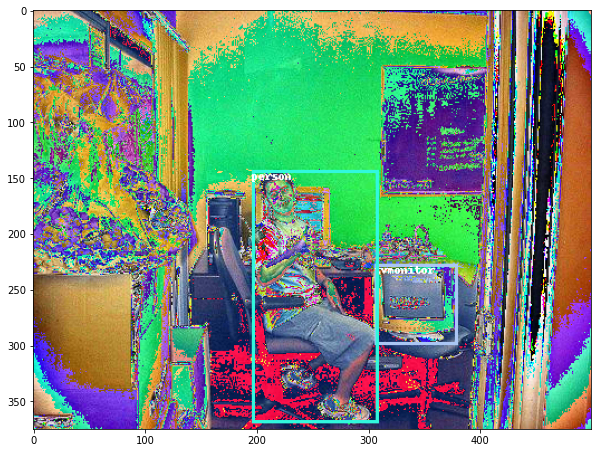

In [11]:
plt.figure(figsize=(10,10))
RS_utils.show(img, target, label, classes = classes)

In [12]:
# transforms 정의
IMAGE_SIZE = 600
scale = 1.0

# 이미지에 padding을 적용하여 종횡비를 유지시키면서 크기가 600x600 되도록 resize 합니다.
train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),
                                  border_mode=cv2.BORDER_CONSTANT),
                    
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

# transforms 적용하기
train_ds.transforms = train_transforms
val_ds.transforms = val_transforms

In [13]:
# 샘플 이미지 확인
idx = np.random.randint(0,100)
img, target, label = train_ds[idx]
colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 색상

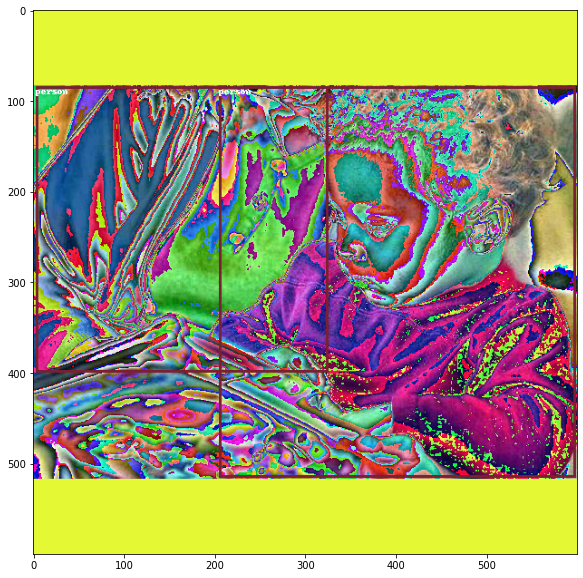

In [14]:
plt.figure(figsize=(10,10))
RS_utils.show(img, target, label, classes = classes)

In [15]:
train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(val_ds, batch_size=4, shuffle=True)

# Modeling 

In [16]:
import torchvision
import torch.nn as nn 

model_resnet50 = torchvision.models.resnet50(pretrained=True)    

In [17]:
# use first 4 layer of resnet 50 
req_layers = list(model_resnet50.children())[:8]
backbone = nn.Sequential(*req_layers)

# unfreeze all the params 
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [18]:
img.shape

torch.Size([3, 600, 600])

In [19]:
#--- exec 
img = img.unsqueeze(0)
out = backbone(img)

In [20]:
out.shape

torch.Size([1, 2048, 19, 19])

In [21]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [22]:
out_c, out_h, out_w

(2048, 19, 19)

In [23]:
img_width = 600
img_height = 600

width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(31, 31)

In [24]:
# Visualize Feature Maps 

out.shape

torch.Size([1, 2048, 19, 19])

In [25]:
out = out.detach().numpy()

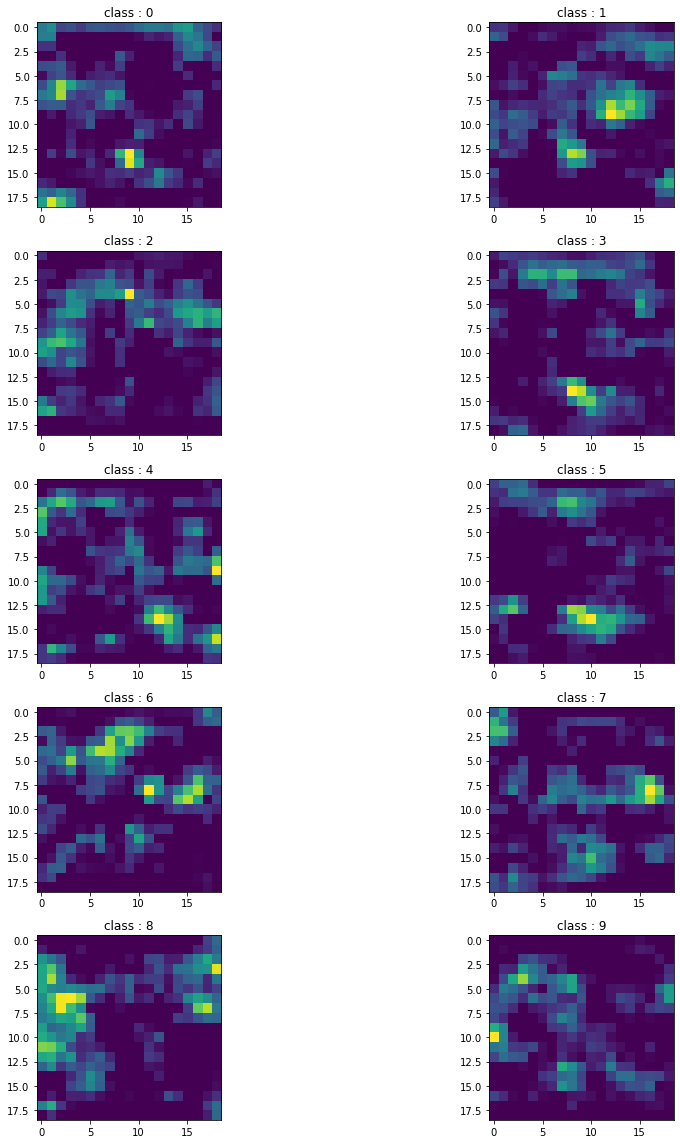

In [26]:
RS_utils.label_display(out, n_class=10, nrows=5, ncols=2, channel_order='torch', batch=True)

In [27]:
# Generate and Plot Anchor points 

anc_pts_x, anc_pts_y = RS_utils.gen_anc_centers(out_size=(out_h, out_w))

In [28]:
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

In [29]:
# display grid function ! 

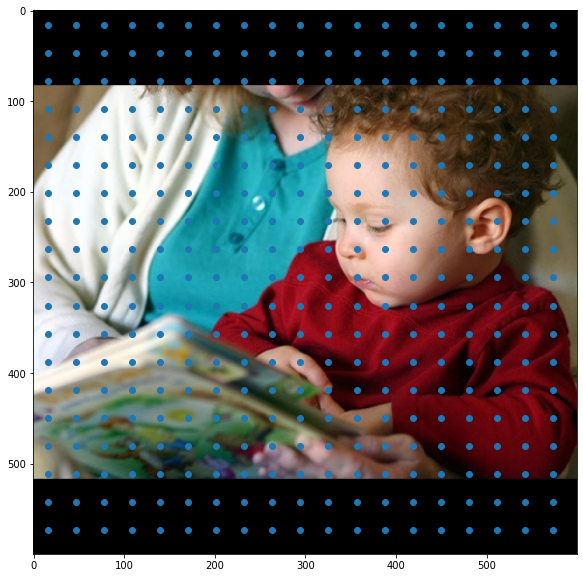

In [30]:
# Visualize 
all_pts = []
for x in anc_pts_x_proj:
    for y in anc_pts_y_proj:
        all_pts.append([x,y])
        
plt.figure(figsize=(10,10))
plt.scatter([i[0] for i in all_pts],[i[1] for i in all_pts])

image_ = RS_utils.torch_denormalize(img[0])
plt.imshow(image_)

#RS_utils.torch_display(img,batch=True)

In [31]:
# Generating Anchor Boxes

anc_scales = [2,4,6]
anc_ratios = [0.5,1,1.5]

n_anc_boxes = len(anc_scales) * len(anc_ratios)

anc_base = RS_utils.gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [32]:
train_ds.__len__()

2501

In [33]:
# since all the images are scaled to the same size 
# we can repeat the anchor base for all the images 

anc_boxes_all = anc_base.repeat(train_ds.__len__(), 1,1,1,1)

In [34]:
anc_boxes_all.shape

torch.Size([2501, 19, 19, 9, 4])

In [35]:
# B - Batch Size
# w_amap - width of the output activation map
# h_wmap - height of the output activation map
# n_anc_boxes - number of anchor boxes per an anchor point
# max_objects - max number of objects in a batch of images
# anc_boxes_tot - total number of anchor boxes in the image i.e, w_amap * h_amap * n_anc_boxes

In [138]:
dataset_ = RS_dataset.myVOCDetection(path2data, year='2007', image_set='train', download=False)

In [149]:
a,b,c= dataset_.__getitem__(0)

In [150]:
a.shape

torch.Size([3, 333, 500])

In [170]:
b

[[156.0, 97.0, 351.0, 270.0]]

In [171]:
b = torch.as_tensor(b)

In [160]:
a,b1,c= dataset_.__getitem__(15)

In [168]:
b1

[[209.0, 187.0, 228.0, 230.0],
 [242.0, 182.0, 274.0, 259.0],
 [269.0, 188.0, 295.0, 259.0]]

In [169]:
b1 = torch.as_tensor(b1)

In [172]:
total_boxes = []
total_boxes.append(b)
total_boxes.append(b1)

In [176]:
total_boxes

[tensor([[156.,  97., 351., 270.]], dtype=torch.float64),
 tensor([[209., 187., 228., 230.],
         [242., 182., 274., 259.],
         [269., 188., 295., 259.]], dtype=torch.float64)]

In [177]:
from torch.nn.utils.rnn import pad_sequence
gt_bboxes_pad = pad_sequence(total_boxes, batch_first=True, padding_value=-1)

In [178]:
gt_bboxes_pad

tensor([[[156.,  97., 351., 270.],
         [ -1.,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  -1.]],

        [[209., 187., 228., 230.],
         [242., 182., 274., 259.],
         [269., 188., 295., 259.]]], dtype=torch.float64)

In [175]:
total_boxes_ = torch.stack(total_boxes)

RuntimeError: stack expects each tensor to be equal size, but got [1, 4] at entry 0 and [3, 4] at entry 1

In [164]:
from torch.nn.utils.rnn import pad_sequence
gt_bboxes_pad = pad_sequence(total_boxes, batch_first=True, padding_value=-1)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [165]:
torch.as_tensor(total_boxes)

TypeError: expected np.ndarray (got list)

In [96]:
A.__version__

'1.3.1'

In [179]:
from glob import glob
import torch 
from torch.nn.utils.rnn import pad_sequence
from albumentations.pytorch.transforms import ToTensorV2

class Detection_Dataset(Dataset):
    
    
    def __init__(self, images, annotations, classes, image_size):
        self.images = sorted(glob(os.path.join(images,"*")))
        self.annotations = sorted(glob(os.path.join(annotations,"*")))
        self.classes = classes
        
        self.trans_normalizer  = transforms.Compose([
            transforms.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])])
        

        self.image_size = image_size
        self.scale = 1.0

        # 이미지에 padding을 적용하여 종횡비를 유지시키면서 크기가 600x600 되도록 resize 합니다.
        self.train_transforms = A.Compose([
                            A.LongestMaxSize(max_size=int(self.image_size * self.scale)),
                            A.PadIfNeeded(min_height=int(self.image_size*self.scale), min_width=int(self.image_size*self.scale),
                                        border_mode=cv2.BORDER_CONSTANT),
                            A.pytorch.ToTensorV2()],
                            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                            )

        self.val_transforms = A.Compose([
                            A.LongestMaxSize(max_size=int(self.image_size * self.scale)),
                            A.PadIfNeeded(min_height=int(self.image_size*self.scale), min_width=int(self.image_size*self.scale),border_mode=cv2.BORDER_CONSTANT),
                            A.pytorch.ToTensorV2()],
                            bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                            )
        
        self.transform = True
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return len(self.images)



    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml => dict
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict
    
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
        
    
    def __getitem__for_(self, index):

        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) 

        targets = [] # bbox coordinates 
        labels = [] # bbox class 

        # get bbox info 
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4])) # bbox coord
            labels.append(label[4])         # bboc class


        if self.transform:
            augmentations = self.train_transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        #-- normalizer 
        img = img.float()
        img = self.trans_normalizer(img)
        
        #-- box, label to tensor 
        targets = torch.tensor(targets)
        labels = torch.tensor(labels)
        

        return img, targets, labels
    
    def get_data(self):
        img_data_all = []
        gt_boxes_all = []
        gt_idxs_all = []
        
        
        #gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(self.images):
            print(i)
            
            img, targets, labels =  self.__getitem__for_(i)        
            #---
            img_data_all.append(img)
            gt_boxes_all.append(targets)
            gt_idxs_all.append(labels)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad
    
    
    
    
    # def collate_fn(self,batch):
    #     images_ = []
    #     targets_ = []
    #     labels_ = []
    #     for a, b, c in batch:
            
    #         images_.append(a)
    #         targets_.append(b)
    #         labels_.append(c)
    #     images_ = torch.stack(images_, dim=0)
        
    #     targets_ = pad_sequence(targets_, batch_first=True, padding_value=-1)
    #     labels_ = pad_sequence(labels_, batch_first=True, padding_value=-1)
        
    #     #targets_ = torch.stack(targets_, dim=0)
    #     #labels_ = torch.stack(labels_, dim=0)

    #     return images_, targets_, labels_

In [180]:
images_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/voc/VOCdevkit/VOC2007/JPEGImages"
anno_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/voc/VOCdevkit/VOC2007/Annotations"

In [181]:
dataset_ = Detection_Dataset(images_path, anno_path, classes, image_size=600)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [189]:
a,b,c, = dataset_.__getitem__(15)

In [190]:
a.shape

torch.Size([3, 600, 600])

In [191]:
b

tensor([[209.4551,  86.4000, 465.1826, 567.6000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],


In [185]:
c

tensor([ 5.,  6.,  6., 14., 14., 14.,  6., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       dtype=torch.float64)

In [127]:
loader_ = DataLoader(dataset_, batch_size=4, collate_fn=dataset_.collate_fn)

In [128]:
a,b,c = next(iter(loader_))

TypeError: expected Tensor as element 0 in argument 0, but got list